Импорт и распаковка

In [1]:
import gdown

file_id = "15IN81Vd2it0n2qCT54bB-hqMZFoF7UbX"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "archive.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=15IN81Vd2it0n2qCT54bB-hqMZFoF7UbX
From (redirected): https://drive.google.com/uc?id=15IN81Vd2it0n2qCT54bB-hqMZFoF7UbX&confirm=t&uuid=b45d3ae1-04cd-4ccf-81a3-026031383ff4
To: /content/archive.zip
100%|██████████| 117M/117M [00:00<00:00, 198MB/s] 


'archive.zip'

In [2]:
import zipfile
import os

extract_dir = "extracted_files"
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall(extract_dir)

os.remove("archive.zip")

Установка модуля ultralytics и остальных зависимостей

In [3]:
!pip install ultralytics

In [4]:
!pip install mediapipe

In [5]:
import sys
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from tabulate import tabulate

import mediapipe as mp

Инициализация модели mediapipe

In [6]:
def init_detector():
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False,
                        model_complexity=1,
                        enable_segmentation=False,
                        min_detection_confidence=0.5,
                        min_tracking_confidence=0.5)
    return pose, mp_pose

Обработка видео

In [7]:
def process_video(pose_module, mp_pose, video_path, output_dir):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    base_name = os.path.splitext(os.path.basename(video_path))[0]

    out_video_path = os.path.join(output_dir, f"{base_name}_result.mp4")
    anomalies_dir = os.path.join(output_dir, "anomalies")
    os.makedirs(anomalies_dir, exist_ok=True)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_video_path, fourcc, fps, (width, height))

    all_keypoints = []
    inference_times = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        start = time.perf_counter()
        results = pose_module.process(img_rgb)
        inference_times.append(time.perf_counter() - start)

        # Собираем ключевые точки
        kp_array = np.zeros((33, 2))
        if results.pose_landmarks:
            h, w, _ = frame.shape
            for idx, lm in enumerate(results.pose_landmarks.landmark):
                kp_array[idx] = [lm.x * w, lm.y * h]
            all_keypoints.append(kp_array)

            # Визуализация bounding box
            x_coords = kp_array[:, 0]
            y_coords = kp_array[:, 1]
            x1, y1 = int(np.min(x_coords)), int(np.min(y_coords))
            x2, y2 = int(np.max(x_coords)), int(np.max(y_coords))
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255,255,0), 2)

        kp_array = np.zeros((33, 2))
        if results.pose_landmarks:
            h, w, _ = frame.shape
            for idx, lm in enumerate(results.pose_landmarks.landmark):
                kp_array[idx] = [lm.x * w, lm.y * h]
            all_keypoints.append(kp_array)

            # Визуализация скелета и соединений
            for x, y in kp_array:
                cv2.circle(frame, (int(x), int(y)), 2, (0,0,255), -1)
            for start_idx, end_idx in mp_pose.POSE_CONNECTIONS:
                x_start, y_start = kp_array[start_idx]
                x_end, y_end = kp_array[end_idx]
                cv2.line(frame,
                         (int(x_start), int(y_start)),
                         (int(x_end), int(y_end)),
                         (0,255,0), 1)
        else:
            all_keypoints.append(np.zeros((33, 2)))

        out.write(frame)

    cap.release()
    out.release()

    # Метрики без эталонных данных:
    # 1) Pose stability: средняя дисперсия координат ключевых точек по времени — показывает стабильность трекинга.
    # 2) Smoothness: среднее ускорение ключевых точек — характеризует плавность движения.
    # 3) Avg inf time: среднее время инференса (мс) — производительность модели.
    # 4) Anomalous frames: количество кадров со скачками позы выше порога (mean + 2*std) — указывает на возможные артефакты.


    points = np.stack(all_keypoints, axis=0)
    # 1) Стабильность позы
    x_var = np.var(points[:, :, 0], axis=0)
    y_var = np.var(points[:, :, 1], axis=0)
    pose_stability = float(np.mean(x_var + y_var))

    # 2) Плавность движения
    vel = np.diff(points, axis=0)
    acc = np.diff(vel, axis=0)
    smoothness = float(np.mean(np.linalg.norm(acc, axis=2)))

    # 3) Среднее время инференса (мс)
    avg_inf_time = float(np.mean(inference_times) * 1000)

    # 4) Поиск аномалий (резкие скачки позы)
    shifts = np.linalg.norm(points[1:] - points[:-1], axis=2)
    max_shift = np.max(shifts, axis=1)
    thr = np.mean(max_shift) + 2 * np.std(max_shift)
    anomaly_idx = np.where(max_shift > thr)[0]

    cap = cv2.VideoCapture(video_path)
    for idx in anomaly_idx:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if ret:
            cv2.imwrite(os.path.join(anomalies_dir, f"{base_name}_frame_{idx}.png"), frame)
    cap.release()

    metrics = [
        ["Pose stability", f"{pose_stability:.2f}"],
        ["Smoothness", f"{smoothness:.2f}"],
        ["Avg inf time (ms)", f"{avg_inf_time:.1f}"],
        ["Anomalous frames", len(anomaly_idx)]
    ]
    print(tabulate(metrics, headers=["Metric","Value"]))

    plt.figure(figsize=(8,3))
    plt.plot(max_shift, label='Max shift')
    plt.axhline(thr, color='r', linestyle='--', label='Threshold')
    plt.title(f"{base_name}: shifts per frame")
    plt.xlabel('Frame'); plt.ylabel('Px'); plt.legend()
    plt.savefig(os.path.join(output_dir, f"{base_name}_shift_plot.png")); plt.close()

    coord_x = points[:, 0, 0]
    coord_y = points[:, 0, 1]
    plt.figure(figsize=(8,3))
    plt.plot(coord_x, label='X0'); plt.plot(coord_y, label='Y0')
    plt.title(f"{base_name}: trajectory kp0")
    plt.xlabel('Frame'); plt.ylabel('Px'); plt.legend()
    plt.savefig(os.path.join(output_dir, f"{base_name}_traj_kp0.png")); plt.close()

    return {
        'video': base_name,
        'pose_stability': pose_stability,
        'smoothness': smoothness,
        'avg_inf_time': avg_inf_time,
        'num_anomalies': len(anomaly_idx)
    }

In [8]:
input_dir = 'extracted_files'
output_dir = 'output_results'

In [16]:
pose_module, mp_pose = init_detector()
os.makedirs(output_dir, exist_ok=True)
results = []
for fname in os.listdir(input_dir):
    if not fname.lower().endswith(('.mp4')):
        continue
    print(f'Processing {fname}...')
    res = process_video(pose_module, mp_pose,
                        os.path.join(input_dir, fname),
                        output_dir)
    results.append(res)

table = [[r['video'],
            f"{r['pose_stability']:.2f}",
            f"{r['smoothness']:.2f}",
            f"{r['avg_inf_time']:.1f}",
            r['num_anomalies']]
            for r in results]
print(tabulate(table, headers=['Video','Stability','Smooth','Inf ms','Anoms']))

Processing 0LtLS9wROrk_E_000731_000738.mp4...
Metric                 Value
-----------------  ---------
Pose stability     122832
Smoothness            107.97
Avg inf time (ms)      40.8
Anomalous frames       19
Video                          Stability    Smooth    Inf ms    Anoms
---------------------------  -----------  --------  --------  -------
0LtLS9wROrk_E_000731_000738       122832    107.97      40.8       19


Визуализация результатов для одного из видео

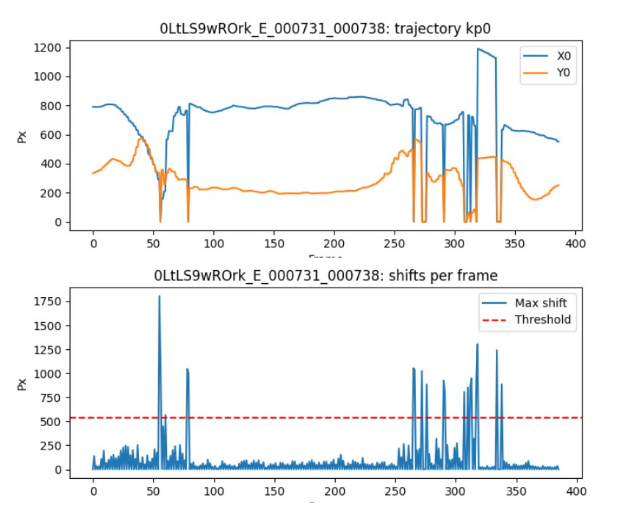

Кадры из одного из результирующих видео

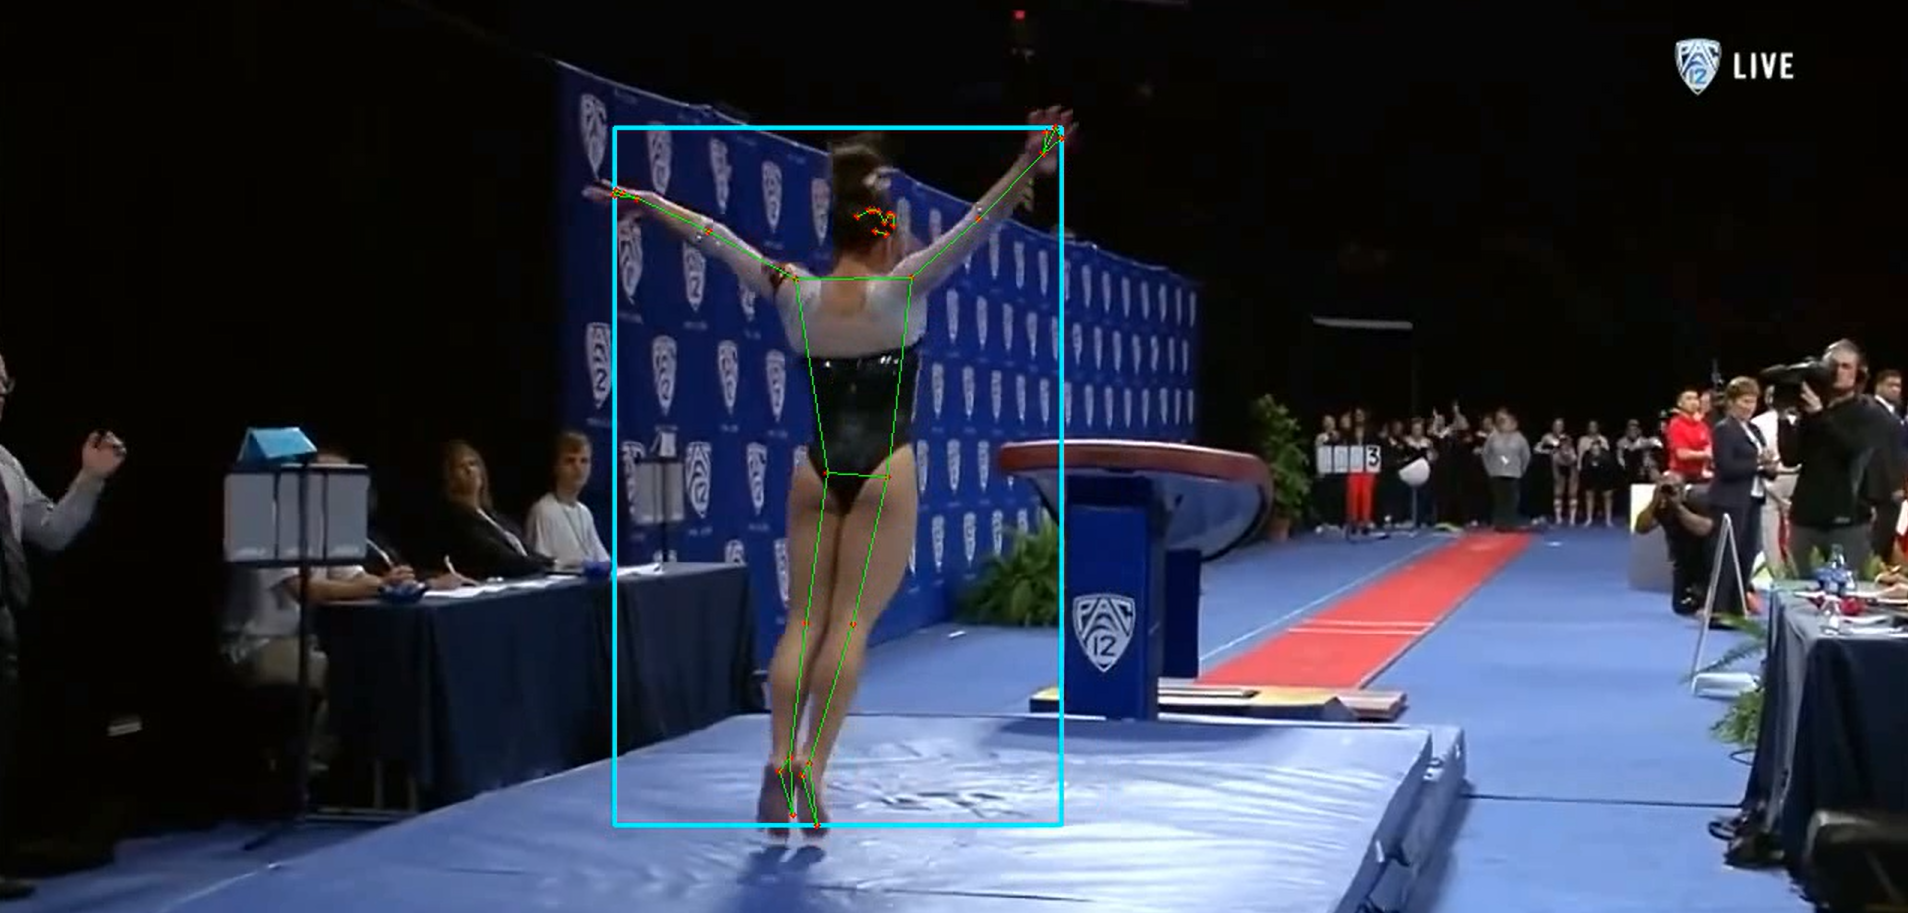

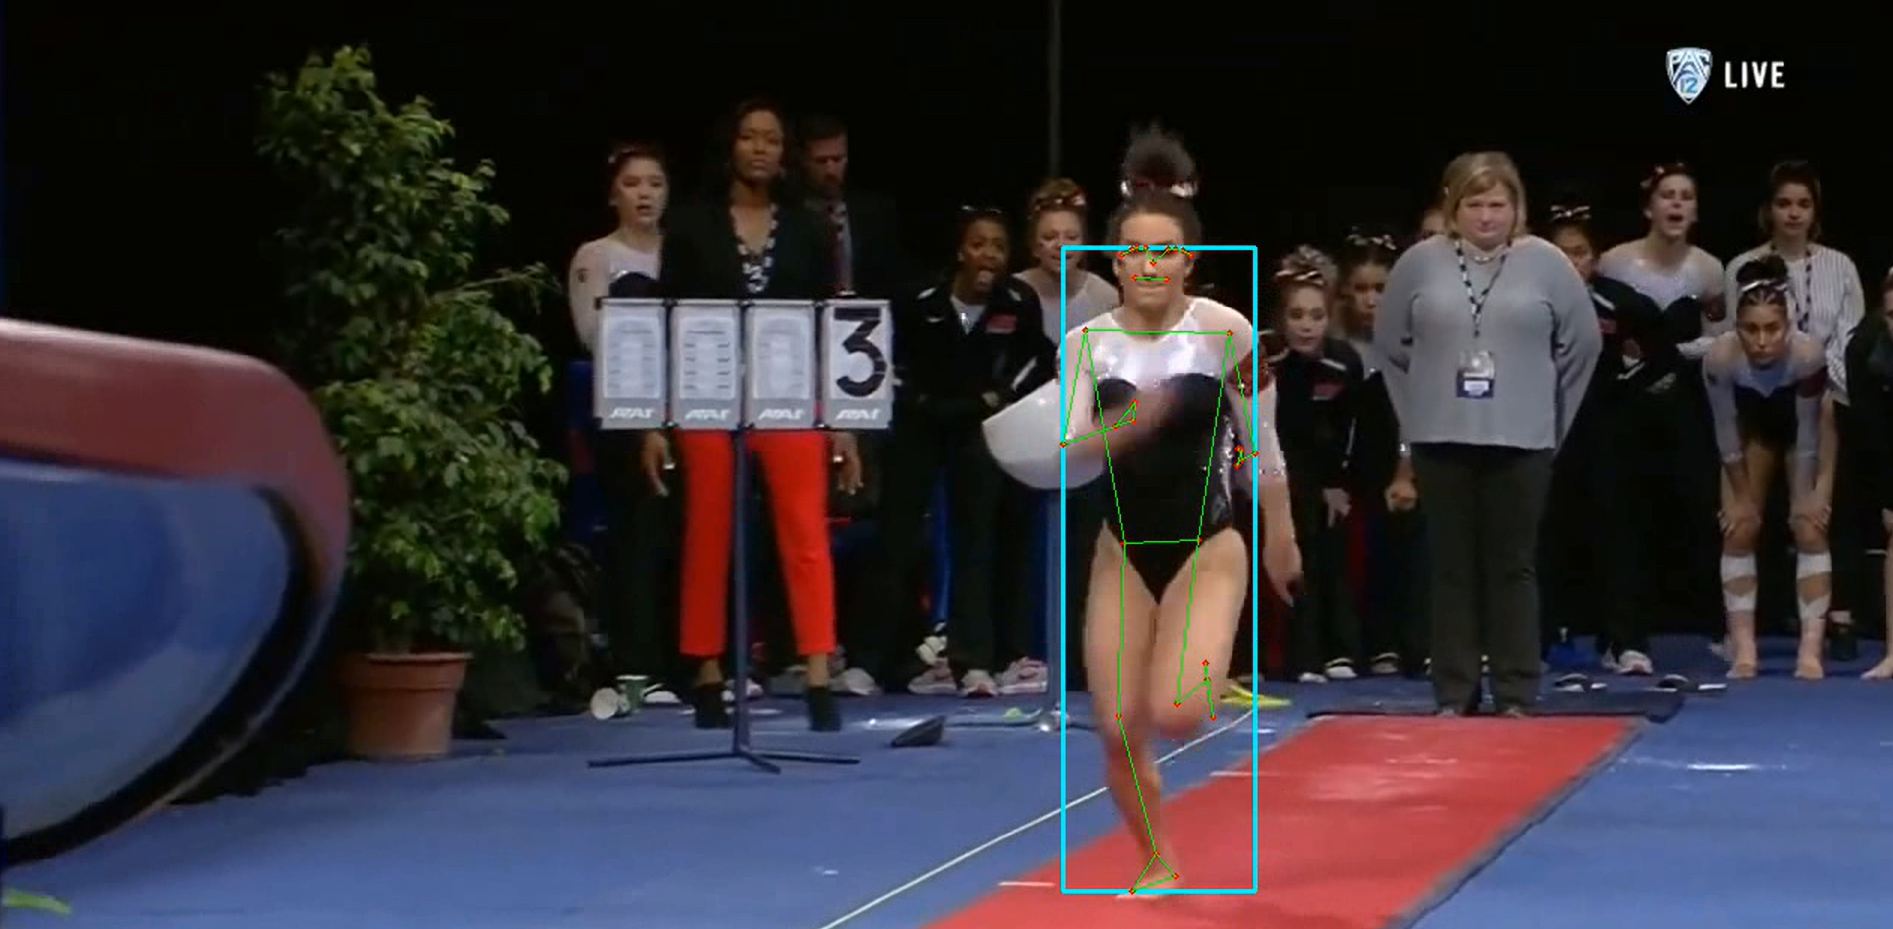

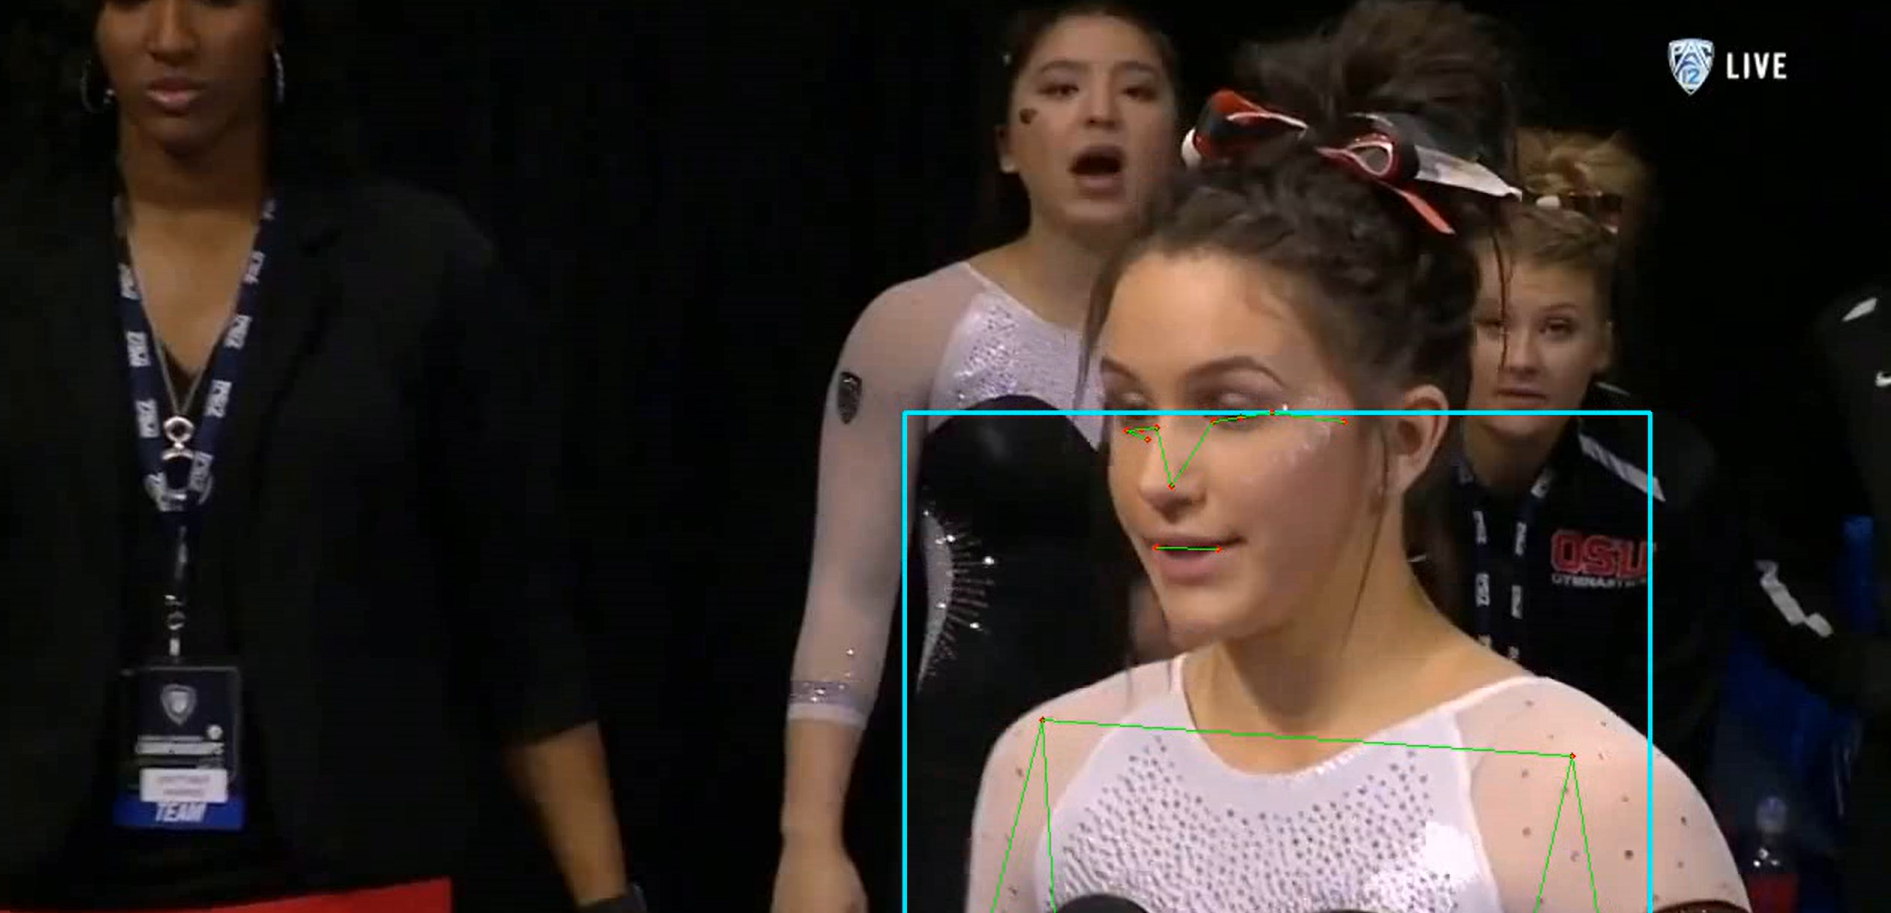

YOLO

In [11]:
from ultralytics import YOLO

def init_yolo_model(model_type='yolov8n-pose.pt'):
    """Инициализация модели YOLO для детекции позы"""
    model = YOLO(model_type)
    return model

In [12]:
def process_video_yolo(model, video_path, output_dir):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    base_name = os.path.splitext(os.path.basename(video_path))[0]

    out_video_path = os.path.join(output_dir, f"{base_name}_yolo_result.mp4")
    anomalies_dir = os.path.join(output_dir, "anomalies_yolo")
    os.makedirs(anomalies_dir, exist_ok=True)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_video_path, fourcc, fps, (width, height))

    all_keypoints = []
    inference_times = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        start_time = time.perf_counter()
        results = model(frame, verbose=False)
        inference_time = time.perf_counter() - start_time
        inference_times.append(inference_time)

        annotated_frame = results[0].plot()
        out.write(annotated_frame)

        kps_array = np.zeros((17, 2))  # 17 точек в YOLO-pose
        if results[0].keypoints is not None:
            kps = results[0].keypoints.xy[0].cpu().numpy()
            if len(kps) > 0:
                kps_array[:len(kps)] = kps

        all_keypoints.append(kps_array)
        frame_count += 1

    cap.release()
    out.release()

    points = np.stack(all_keypoints, axis=0)

    # 1) Стабильность позы
    x_var = np.var(points[:, :, 0], axis=0)
    y_var = np.var(points[:, :, 1], axis=0)
    pose_stability = float(np.mean(x_var + y_var))

    # 2) Плавность движения
    vel = np.diff(points, axis=0)
    acc = np.diff(vel, axis=0)
    smoothness = float(np.mean(np.linalg.norm(acc, axis=2)))

    # 3) Среднее время инференса (мс)
    avg_inf_time = float(np.mean(inference_times) * 1000)

    # 4) Поиск аномалий
    shifts = np.linalg.norm(points[1:] - points[:-1], axis=2)
    max_shift = np.max(shifts, axis=1) if shifts.size > 0 else np.array([])
    thr = np.mean(max_shift) + 2 * np.std(max_shift) if max_shift.size > 0 else 0
    anomaly_idx = np.where(max_shift > thr)[0] if max_shift.size > 0 else []

    cap = cv2.VideoCapture(video_path)
    for idx in anomaly_idx:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if ret:
            cv2.imwrite(os.path.join(anomalies_dir, f"{base_name}_frame_{idx}.png"), frame)
    cap.release()

    plt.figure(figsize=(8,3))
    if max_shift.size > 0:
        plt.plot(max_shift, label='Max shift')
        plt.axhline(thr, color='r', linestyle='--', label='Threshold')
    plt.title(f"{base_name}: shifts per frame (YOLO)")
    plt.xlabel('Frame')
    plt.ylabel('Px')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"{base_name}_yolo_shift_plot.png"))
    plt.close()

    if points.shape[0] > 0:
        coord_x = points[:, 0, 0]
        coord_y = points[:, 0, 1]
        plt.figure(figsize=(8,3))
        plt.plot(coord_x, label='X0')
        plt.plot(coord_y, label='Y0')
        plt.title(f"{base_name}: trajectory kp0 (YOLO)")
        plt.xlabel('Frame')
        plt.ylabel('Px')
        plt.legend()
        plt.savefig(os.path.join(output_dir, f"{base_name}_yolo_traj_kp0.png"))
        plt.close()

    metrics = [
        ["Pose stability", f"{pose_stability:.2f}"],
        ["Smoothness", f"{smoothness:.2f}"],
        ["Avg inf time (ms)", f"{avg_inf_time:.1f}"],
        ["Anomalous frames", len(anomaly_idx)]
    ]
    print(tabulate(metrics, headers=["Metric", "Value"]))

    return {
        'video': base_name,
        'pose_stability': pose_stability,
        'smoothness': smoothness,
        'avg_inf_time': avg_inf_time,
        'num_anomalies': len(anomaly_idx)
    }

In [13]:
output_dir = 'output_results_yolo'
os.makedirs(output_dir, exist_ok=True)

In [14]:
models = {
    'yolov8n-pose': 'yolov8n-pose.pt',  # Нано-модель
    'yolov8s-pose': 'yolov8s-pose.pt',  # Малая модель
    'yolov8m-pose': 'yolov8m-pose.pt'   # Средняя модель
}

In [17]:
all_results = {}

for model_name, model_path in models.items():
    print(f"\n{'='*40}")
    print(f"Processing with {model_name}")
    print(f"{'='*40}")

    model = init_yolo_model(model_path)
    model_results = []

    for fname in os.listdir(input_dir):
        if not fname.lower().endswith('.mp4'):
            continue

        print(f'Processing {fname} with {model_name}...')
        res = process_video_yolo(
            model,
            os.path.join(input_dir, fname),
            output_dir
        )
        res['model'] = model_name
        model_results.append(res)

    all_results[model_name] = model_results

print("\nComparative Results:")
comparison_table = []

for model_name, results in all_results.items():
    for res in results:
        comparison_table.append([
            res['video'],
            res['model'],
            f"{res['pose_stability']:.2f}",
            f"{res['smoothness']:.2f}",
            f"{res['avg_inf_time']:.1f}",
            res['num_anomalies']
        ])

print(tabulate(comparison_table,
               headers=['Video', 'Model', 'Stability', 'Smooth', 'Inf ms', 'Anoms'],
               tablefmt='grid'))


Processing with yolov8n-pose
Processing 0LtLS9wROrk_E_000731_000738.mp4 with yolov8n-pose...
Metric                Value
-----------------  --------
Pose stability     138370
Smoothness            233.9
Avg inf time (ms)     168.2
Anomalous frames       17

Processing with yolov8s-pose


100%|██████████| 22.4M/22.4M [00:00<00:00, 224MB/s]


Processing 0LtLS9wROrk_E_000731_000738.mp4 with yolov8s-pose...
Metric                 Value
-----------------  ---------
Pose stability     109765
Smoothness            219.92
Avg inf time (ms)     449.4
Anomalous frames       18

Processing with yolov8m-pose


100%|██████████| 50.8M/50.8M [00:00<00:00, 370MB/s]


Processing 0LtLS9wROrk_E_000731_000738.mp4 with yolov8m-pose...
Metric                 Value
-----------------  ---------
Pose stability     142934
Smoothness            225.79
Avg inf time (ms)    1056.8
Anomalous frames       22

Comparative Results:
+-----------------------------+--------------+-------------+----------+----------+---------+
| Video                       | Model        |   Stability |   Smooth |   Inf ms |   Anoms |
+=============================+==============+=============+==========+==========+=========+
| 0LtLS9wROrk_E_000731_000738 | yolov8n-pose |      138370 |   233.9  |    168.2 |      17 |
+-----------------------------+--------------+-------------+----------+----------+---------+
| 0LtLS9wROrk_E_000731_000738 | yolov8s-pose |      109765 |   219.92 |    449.4 |      18 |
+-----------------------------+--------------+-------------+----------+----------+---------+
| 0LtLS9wROrk_E_000731_000738 | yolov8m-pose |      142934 |   225.79 |   1056.8 |      22 |
+--

Пример результатов метрик

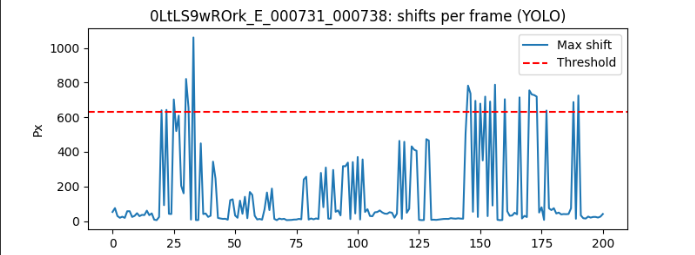

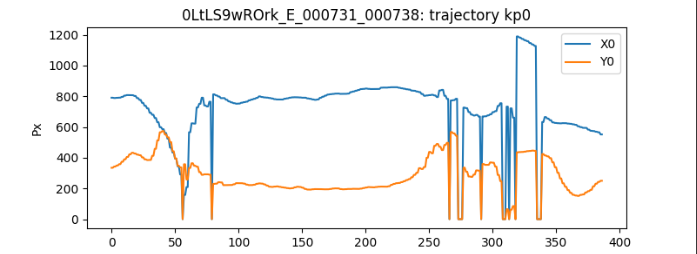